# Learning equations from data

This notebook shows how convex optimization allows one to learn equations that govern a dynamical system from measurement data. Here we apply the ideas to the simple logistic map

\begin{equation}
    x_{n+1} = \lambda x_n (1-x_n)
\end{equation}

where $\lambda \in (0,4)$ is a fixed parameter that determine how the sequence $x_0,\,x_1,\,\ldots$ evolves with $n$. The initial condition $x_0$ is taken to be in the interval $[0,1]$. See the [Wikipedia page](https://en.wikipedia.org/wiki/Logistic_map) to learn more about the logistic map and its dynamics.

## Generating data

We begin by loading packages and generating data. You can change the value of $\lambda$ and re-run the notebook to see how this changes things.

In [1]:
using Plots
using LaTeXStrings
using JuMP
using CSDP

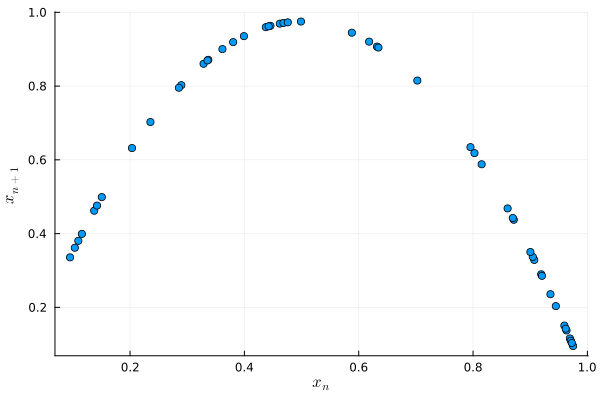

In [2]:
λ = 3.9# value of λ
m = 50 # number of data points
x = zeros(Float64, m)
x[1] = rand()
for n in 1:m-1
    x[n+1] = λ * x[n] * (1 - x[n])
end
scatter(x[1:m-1], x[2:m], xlabel=L"x_n", ylabel=L"x_{n+1}", label="")

## Setting up the optimization problem

Next, we set up the optimization problem to learn the equation $x_{n+1}=\lambda x_n (1-x_n)$ from the data we generated. Do do so, we fix a vector (or "dictionary") of monomials $m(x) = \{1,x,x^2,\ldots,x^d\}$ for some fixed degree $d$ and seek coefficients $c=(c_1,\ldots,c_{d+1})$ that solve the minimization problem

\begin{equation}
    \min_{c \in \mathbb{R}^{d+1}} \quad \sum_{i=1}^{m-1} |x_{n+1} - c \cdot m(x_n)|
\end{equation}

To solve this problem, we "lift" the absolute values by introducing "slack" variables $s_1,\ldots,s_{m-1}$ such that $|x_{n+1} - c \cdot m(x_n)|\leq s_n$ for $n=1,\ldots,m-1$. Thus, we solve

\begin{align*}
    \min_{\substack{c \in \mathbb{R}^{d+1} \\ s \in \mathbb{R}^{m-1}}} \quad &\sum_{n=1}^{m-1} s_n
    \\
    \text{s.t.} \quad & -s_n \leq x_{n+1} - c \cdot m(x_n) \leq s_n \quad \forall n \in \{1,\ldots,m\}
\end{align*}

In [7]:
γ = 0  # the penalty parameter for the cost
d = 2  # the degree parameter
model = Model() # create a new optimization problem with JuMP
set_optimizer(model, CSDP.Optimizer) # set the optimizer
@variable(model, c[1:d+1])  # optimization variables c1, ..., cd
@variable(model, s[1:m-1])  # optimization variables s1, ..., sm
res = x[2:m] .- ( x[1:m-1] .^ (0:d)' ) * c # model residual at each data point
@constraint(model, res .<= s)
@constraint(model, res .>= -s)
@objective(model, Min, sum(s))
optimize!(model)

CSDP 6.2.0
Iter:  0 Ap: 0.00e+00 Pobj:  0.0000000e+00 Ad: 0.00e+00 Dobj:  0.0000000e+00 
Iter:  1 Ap: 1.00e+00 Pobj: -4.8693233e+02 Ad: 8.62e-01 Dobj: -1.1439888e+00 
Iter:  2 Ap: 1.00e+00 Pobj: -3.7441227e+02 Ad: 9.15e-01 Dobj: -1.2630516e-01 
Iter:  3 Ap: 1.00e+00 Pobj: -5.1102195e+01 Ad: 9.06e-01 Dobj:  1.0486862e-02 
Iter:  4 Ap: 9.89e-01 Pobj: -2.4768844e+00 Ad: 9.31e-01 Dobj: -1.2522365e-04 
Iter:  5 Ap: 9.93e-01 Pobj: -1.1062459e-01 Ad: 9.53e-01 Dobj:  1.9901621e-07 
Iter:  6 Ap: 9.95e-01 Pobj: -4.7426248e-03 Ad: 9.74e-01 Dobj: -4.5392472e-07 
Iter:  7 Ap: 1.00e+00 Pobj: -5.9013797e-04 Ad: 1.00e+00 Dobj: -7.5817621e-07 
Iter:  8 Ap: 1.00e+00 Pobj: -1.0937046e-04 Ad: 1.00e+00 Dobj: -2.3364050e-06 
Iter:  9 Ap: 1.00e+00 Pobj: -3.0578570e-05 Ad: 1.00e+00 Dobj: -5.1779386e-06 
Iter: 10 Ap: 1.00e+00 Pobj: -1.8364778e-06 Ad: 1.00e+00 Dobj: -5.3980259e-06 
Iter: 11 Ap: 1.00e+00 Pobj: -2.2529079e-07 Ad: 1.00e+00 Dobj: -1.2607142e-06 
Iter: 12 Ap: 1.00e+00 Pobj: -1.6322839e-08 Ad: 1.00e+

The optimal $c$ is

In [8]:
cval = value.(c)

3-element Vector{Float64}:
 -8.436740889239402e-12
  3.900000000039128
 -3.900000000033814

giving the model $x_{n+1} = f(x_n)$ with

In [9]:
print("f(x) = ")
for (i, coef) in enumerate(reverse(cval))
    coef == 0 && continue
    ex = length(cval) - i
    print(' ', coef > 0 ? '+' : '-', ' ')
    print(abs(coef))
    ex > 0 && print('x')
    ex > 1 && print('^', ex)
end

f(x) =  - 3.900000000033814x^2 + 3.900000000039128x - 8.436740889239402e-12

The exact model would have

In [10]:
print("f(x) = ", λ, "x - ", λ, "x^2")

f(x) = 3.9x - 3.9x^2

This concludes the example -- now you can try to discover your preferred dynamical system!